In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
table = read_csv('/content/drive/MyDrive/QuadrantiSchivenoglia.csv')
table.head()

Unnamed: 0        Date  Ammonia  PM10  PM25  Wind_speed  Temperature  \
0           0  2014-01-01     14.1  56.0  56.0    1.508213     4.766667   
1           1  2014-01-02     19.4  56.0  55.0    0.390941     5.479167   
2           2  2014-01-03     10.2  43.0  39.0    2.104680     5.766667   
3           3  2014-01-04      8.6  37.0  33.0    0.949083     6.950000   
4           4  2014-01-05      7.7  18.0  16.0    1.130128     7.541667   

   Rainfall  Quadrante  
0       0.2          3  
1       2.0          4  
2       1.4          3  
3       5.8          2  
4      14.2          3

In [4]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
Moggio = table.loc[:,["Date","Ammonia","PM10","PM25","Wind_speed","Quadrante","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


index        Date  Ammonia  PM10  PM25  Wind_speed  Quadrante  Temperature  \
0      0  2014-01-01     14.1  56.0  56.0    1.508213          3     4.766667   
1      1  2014-01-02     19.4  56.0  55.0    0.390941          4     5.479167   
2      2  2014-01-03     10.2  43.0  39.0    2.104680          3     5.766667   
3      3  2014-01-04      8.6  37.0  33.0    0.949083          2     6.950000   
4      4  2014-01-05      7.7  18.0  16.0    1.130128          3     7.541667   

   Rainfall  
0       0.2  
1       2.0  
2       1.4  
3       5.8  
4      14.2

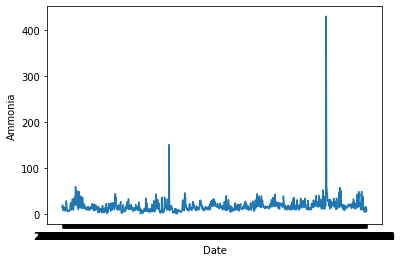

In [5]:
sns.lineplot(x='Date', y='Ammonia', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [6]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [7]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)

reframed.head()

var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.032745   0.327161   0.450820   0.178967   0.666667   0.562163   
6   0.045053   0.327161   0.442623   0.044953   1.000000   0.573684   
7   0.023688   0.246914   0.311475   0.250511   0.666667   0.578333   
8   0.019972   0.209877   0.262295   0.111901   0.333333   0.597467   
9   0.017882   0.092593   0.122951   0.133617   0.666667   0.607034   

   var7(t-5)  var1(t-4)  var2(t-4)  var3(t-4)  ...  var6(t-2)  var7(t-2)  \
5   0.003846   0.045053   0.327161   0.442623  ...   0.597467   0.111538   
6   0.038462   0.023688   0.246914   0.311475  ...   0.607034   0.273077   
7   0.026923   0.019972   0.209877   0.262295  ...   0.638093   0.000000   
8   0.111538   0.017882   0.092593   0.122951  ...   0.613973   0.003846   
9   0.273077   0.031584   0.141975   0.196721  ...   0.619565   0.000000   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
5   0.017882   0.092593   0.122951   0.133617   0.666667   0.607034   
6   0.031584   0.141975   0.196721   0.207754   1.000000   0.638093   
7   0.033442   0.308642   0.418033   0.122895   0.666667   0.613973   
8   0.032745   0.228395   0.303279   0.085629   0.333333   0.619565   
9   0.034835   0.481481   0.459016   0.037766   1.000000   0.649344   

   var7(t-1)   var1(t)  
5   0.273077  0.031584  
6   0.000000  0.033442  
7   0.003846  0.032745  
8   0.000000  0.034835  
9   0.000000  0.034371  

[5 rows x 36 columns]

In [8]:
# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first few year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 35) 1312 (1312,)
(1312, 5, 7) (1312,) (22, 5, 7) (22,)


# Modeling and training

Epoch 1/500
27/27 - 9s - loss: 0.0188 - val_loss: 0.0199 - 9s/epoch - 335ms/step
Epoch 2/500
27/27 - 0s - loss: 0.0175 - val_loss: 0.0231 - 400ms/epoch - 15ms/step
Epoch 3/500
27/27 - 0s - loss: 0.0175 - val_loss: 0.0256 - 385ms/epoch - 14ms/step
Epoch 4/500
27/27 - 0s - loss: 0.0187 - val_loss: 0.0271 - 396ms/epoch - 15ms/step
Epoch 5/500
27/27 - 0s - loss: 0.0195 - val_loss: 0.0275 - 379ms/epoch - 14ms/step
Epoch 6/500
27/27 - 0s - loss: 0.0205 - val_loss: 0.0249 - 395ms/epoch - 15ms/step
Epoch 7/500
27/27 - 0s - loss: 0.0205 - val_loss: 0.0220 - 407ms/epoch - 15ms/step
Epoch 8/500
27/27 - 0s - loss: 0.0198 - val_loss: 0.0196 - 423ms/epoch - 16ms/step
Epoch 9/500
27/27 - 0s - loss: 0.0187 - val_loss: 0.0194 - 390ms/epoch - 14ms/step
Epoch 10/500
27/27 - 0s - loss: 0.0185 - val_loss: 0.0193 - 404ms/epoch - 15ms/step
Epoch 11/500
27/27 - 0s - loss: 0.0185 - val_loss: 0.0192 - 378ms/epoch - 14ms/step
Epoch 12/500
27/27 - 0s - loss: 0.0184 - val_loss: 0.0191 - 404ms/epoch - 15ms/step
Epo

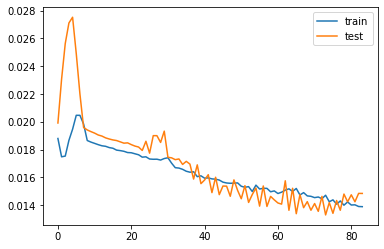

In [9]:
# design the neural network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=10, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions of the year 2019

In [10]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.623


#### Prediciton plots

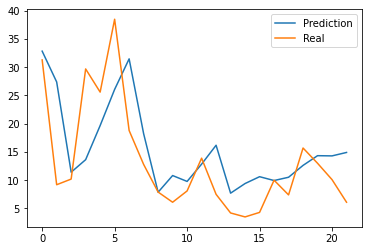

In [11]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()

# Modeling with hyperparamenter search
# Goal: reduce the MSE without overfitting

In [12]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 2.9 MB/s 


In [13]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt #Keras Creates a better model

In [14]:
tf.config.list_physical_devices('GPU') #To undestand which GPU using during the training

[]

## Function to create new models

In [15]:
def model_builder(hp):
  #design network
  #object created with keras_tuner -> iterates some parameters to create the model
  #units = neurons we use 32 steps for each time
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  #Initialization of the model
  model = Sequential() 
  model.add(LSTM(units = hp_units,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  #for loop to iterate different quantities of layer (from 1 to 3 layer)
  for i in range(hp.Int('layers',1,3)):
   model.add(LSTM(units = hp_units, return_sequences=True))
  model.add(LSTM(units = hp_units, return_sequences=False))
  model.add(Dense(1))
  #Choose from a list of given instructions -> we choose leanrning rates
  #We look the performances
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
  return model

# Creation of the object with model_builder(hp)
## Parameter to look at: validation loss

In [16]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial =3,
    directory = 'dir',
    project_name = 'namee')
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [17]:
train_X, train_y = train[:, :n_obs], train[:, -1]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))

In [18]:
train_X.shape

(1312, 5, 7)

In [19]:
train_y.shape

(1312,)

In [20]:
train_y = train_y.reshape((train_.shape[0], n_days, n_features))

NameError: ignored

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
tuner.search(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])

In [ ]:
tuner.results_summary()

### Hyperband

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
tuner.search(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])